## IMPORT RELEVANT LIBRARIES

In [1]:
# DATA EXTRACTION
import glob
import os

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visulization
from    missingno import matrix
from    skimpy    import skim
import  matplotlib.pyplot as plt
import  seaborn as sns 

# Data Information 

#### Class information
<img src="data types.jpg">



## DATA EXTRACTION 

- Collect the directories of all files 
- Obtain each data
- Aggregate data by choosen metric 
    - Time range - 5 Minutes
    - Aggregator - Median
- Join all in a data frame using a loop and the pd.concat statement

In [2]:
# Establish root dir wher files resides
# This depends on your PC, Find the directory to the 3W folder
root_dir = r"C:\Users\Owner\Desktop\IT\Group project - W3\3W"

# Get all file Diretiories 
directiories = []
for i in range(0,9):
    directiories.append(root_dir  + f'\\{i}')

# Extract all file names directories 
files = []
for dir_name in directiories:
    files = files + glob.glob(os.path.join(dir_name, "*.csv"))

## DATA WRANGLING
- Data aggregation by hours   and class
- Data aggregation(use median for agg, or use max - min/2 ) by minutes(1, 10) and class


In [3]:
def data_collect(directory, time ,style ):
    '''
    This code aggregates each individual file 
    
    styles include - median, midrange, max, min, mode
    
    '''
    return pd.read_csv(directory, parse_dates= [0]).resample(time, on = 'timestamp').agg(style).reset_index()
    

def joinall(files, time = '10T', style = 'median'):
    '''
    This code block empasizes om joining each aggregated dataframe together
    '''
    
    ct = 0
    
    for dir_ in files:
         
        if ct == 0 :
            df = data_collect(dir_ , time, style)    
        else:
            df = pd.concat([df,data_collect(dir_, time, style)], axis = 0)
            
        ct+= 1
        
    return df.reset_index(drop =True)

In [4]:
df = joinall(files, time = '1T', style = 'median')
df.to_csv('combined_1mins_median.csv', index = False)

## DATA CLEANING 

> - Check for speling inconsitencies -- There are no string to check for inconsitencies
> - Check is missing /null data 
> - Check or duplicates
> - Check for data types
> - Outlier Detection

In [5]:
# Have a glimpse of the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850591 entries, 0 to 850590
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   timestamp   850591 non-null  datetime64[ns]
 1   P-PDG       850520 non-null  float64       
 2   P-TPT       850517 non-null  float64       
 3   T-TPT       753558 non-null  float64       
 4   P-MON-CKP   831839 non-null  float64       
 5   T-JUS-CKP   822128 non-null  float64       
 6   P-JUS-CKGL  169005 non-null  float64       
 7   T-JUS-CKGL  0 non-null       float64       
 8   QGL         180531 non-null  float64       
 9   class       850556 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 64.9 MB


<AxesSubplot:>

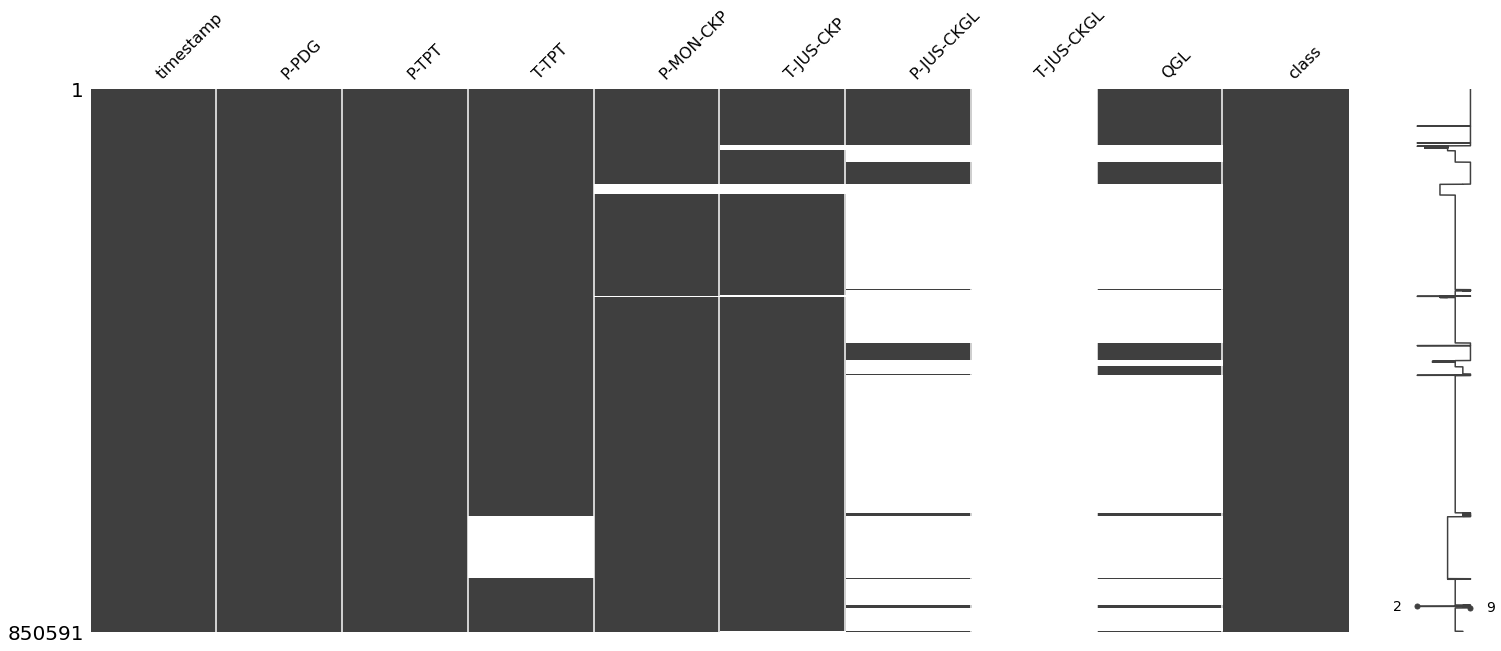

In [6]:
# Disover requencies of misssing data visually
matrix(df)

In [7]:
# Percentage of missing values per column

def per_missing(df):
    '''
    Finds the percentage of missing values in each column
    '''
    tot_len = len(df)
    
    per_missing = df.isna().sum().to_frame()
    per_missing['% missing'] = (per_missing[0]/tot_len) *100
    return per_missing.drop(columns = [0]).sort_values(by = ['% missing'], ascending= False)

per_missing(df)

,% missing
T-JUS-CKGL,100.000000
P-JUS-CKGL,80.130874
QGL,78.775816
T-TPT,11.407715
T-JUS-CKP,3.346262
P-MON-CKP,2.204585
P-TPT,0.008700
P-PDG,0.008347
class,0.004115
timestamp,0.000000


##### There are 3 Columns with alot of missing data(> 50%)
> - P-JUS-CKGL     
> - T-JUS-CKGL     
> - QGL    
Solution - Drop Columns
***

##### Others have just a few(>1% but < 15%>)
> - T-TPT    - check if the missing data are from the same class      
>     - yes , drop columns or drop class(opt)
>     - no  , fill with iterative imputer  
> - P-MON-CKP      
> - T-JUS-CKP  
Solution -  fill missing with Sklearn.iterative_imputer 
***

Also, the class column has some missing column 
Solution - drop rows with missing class
Lets Check the pecentage of missing data in those columns 

In [8]:
# Explore T-TPT columnsdf
missing_T_TPT_class =  df['class'][df['T-TPT'].isna()]
missing_T_TPT_class.value_counts().sort_index()

0.0       6593
3.0          8
4.0          9
6.0      64547
53.0         5
56.0         4
106.0    25862
107.0        5
Name: class, dtype: int64

In [193]:
# We see that the class 6 - Quick Restriction in PCK has alot of missing data
# Our quick guess is to check the percentage of missing data comes from the class = 6

missing_TPT = (64547 + 25862)/(len(df[df['class'] == 6]) + len(df[df['class'] == 106]))

print(f'{(missing_TPT * 100): 1f}% of TPT values that cointains 6 or 106 are missing')

# This simply implies that ue cannot use the T-TPT column if we want to classify the a condition, it will certainly be baised

"""
POSSIBLE SOLUTIONS 
 - Drop all values that cointain 6 or 106, there fore limiting the ability to predict that condition
 - Drop the T-TPT column 
"""
df1 = df.drop(columns=['T-JUS-CKGL','P-JUS-CKGL','QGL','T-TPT'])

 99.637418% of TPT values that cointains 6 or 106 are missing


#### CLEANING CLASS COLUMN

In [194]:
df1['class'].value_counts().sort_index()

0.0      200642
1.0       48495
2.0        6056
3.0       80677
4.0       41477
5.0      176064
6.0       64767
7.0        1812
8.0       10135
50.5          2
51.0          2
52.5          7
53.0          5
54.0          1
55.0          9
56.0          4
101.0     87975
102.0      2446
105.0     40346
106.0     25971
107.0     38365
108.0     25298
Name: class, dtype: int64

In [195]:
#compare the use of foward and backward fill
dfx = df1[['class','timestamp']].copy()
dfx['backfill']  = dfx['class'].fillna(method='backfill')
dfx['ffill']     = dfx['class'].fillna(method='pad')

dfx.iloc[list(df1[df1['class'].isna()].index), -2:]

,backfill,ffill
314811,1.0,101.0
315151,101.0,0.0
315152,101.0,0.0
315153,101.0,0.0
315154,101.0,0.0
315155,101.0,0.0
315156,101.0,0.0
315805,101.0,0.0
315806,101.0,0.0
316157,1.0,101.0


> The nulls, look so much as the transient periods between a normal and a steady state.
> Without much certainty of this is, where this chages resides and considering it is a very minute portion os the data set,
> it would be best to drop nulls

In [196]:
#Find null class --- There are no null classes 
print('There are',df1['class'].isna().sum(), 'missing values in the class column')
print('which is',(df1['class'].isna().sum()/len(df1))*100, 'of the entire data')

There are 35 missing values in the class column
which is 0.004114786072272103 of the entire data


In [197]:
# The classes 10 - 100 are error, considering our class information, so we drop then
# Since class are our target variables, it would not be a great to fill it 
# This also drp the null values
df1  = (df1[(df1['class'] < 10) | (df1['class'] > 100)])

In [198]:
# Filter out all null values 
df1 = df1[df1['class'].notna()]
per_missing(df1)

,% missing
T-JUS-CKP,3.346400
P-MON-CKP,2.204753
P-TPT,0.008700
P-PDG,0.008348
timestamp,0.000000
class,0.000000


##### OUTLIER DETECTION 

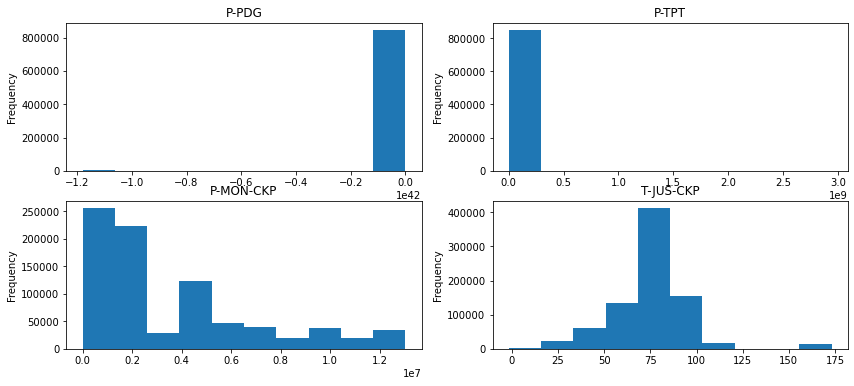

In [199]:
plot_objects = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
fig, ((ax1, ax2), (ax3, ax4)) = plot_objects

axes_ = (ax1, ax2, ax3, ax4)
for i in enumerate(axes_):
    df1.iloc[: , i[0]+1].plot(kind  = 'hist', 
                          title = df1.columns[i[0]+1] , 
                          ax = i[1])

Consider the __P-PDG__ & __P-TPT__ do not alot of outliers

In [200]:
# FULL DISTRIBUTION
df1[['P-PDG' ,'P-TPT']].quantile(np.linspace(0,1,11))

,P-PDG,P-TPT
0.0,-1.180116e+42,0.000000e+00
0.1,0.000000e+00,8.002606e+06
0.2,2.506680e+02,9.464804e+06
0.3,1.694630e+07,1.210082e+07
0.4,2.031564e+07,1.350474e+07
0.5,2.189268e+07,1.452601e+07
0.6,2.366027e+07,1.566652e+07
0.7,2.520684e+07,1.675082e+07
0.8,2.632614e+07,1.821633e+07
0.9,2.904754e+07,2.077159e+07


In [202]:
# TOP 5 PERCENTILE 
df1[['P-PDG' ,'P-TPT']].quantile(np.linspace(0,0.05,11))


#1% OF THE P-PDG VALUES ARE NECESARRY SKEWED 

,P-PDG,P-TPT
0.000,-1.180116e+42,0.000000
0.005,-6.887865e+06,89.761256
0.010,-6.887865e+06,94.641741
0.015,0.000000e+00,116.256580
0.020,0.000000e+00,135.122100
0.025,0.000000e+00,135.353427
0.030,0.000000e+00,135.724900
0.035,0.000000e+00,136.474718
0.040,0.000000e+00,159.033400
0.045,0.000000e+00,159.676424


In [204]:
# BOTTOM 1 PERCENTILE 
df1[['P-PDG' ,'P-TPT']].quantile(np.linspace(0.99,1,11))

,P-PDG,P-TPT
0.990,4.485805e+07,2.817836e+07
0.991,4.485805e+07,2.822099e+07
0.992,4.485805e+07,2.839609e+07
0.993,4.485805e+07,2.874850e+07
0.994,4.485805e+07,2.911438e+07
0.995,4.485805e+07,2.938450e+07
0.996,4.485805e+07,2.964256e+07
0.997,4.485805e+07,3.026173e+07
0.998,4.485805e+07,3.202548e+07
0.999,4.485805e+07,6.793571e+08


In [205]:
##Clean the data. Filter out OUTLIERS 

df2 = df1[  (df1['P-PDG'] >= df1['P-PDG'].quantile(0.015))
          & (df1['P-PDG'] <= df1['P-PDG'].quantile(0.999))   
          & (df1['P-TPT'] <= df1['P-TPT'].quantile(0.9985))
          ]

In [206]:
## Fill missing wih a bayelsan ridgw regressor usking the sklean.iterative_imputer 

# from sklearn.experimental   import enable_iterative_imputer
# from sklearn.impute         import IterativeImputer
# from catboost               import CatBoostRegressor
# 
# df2 = df2.iloc[:,1:].copy()
# 
# imputer = IterativeImputer( 
#                             verbose   = 2,
#                             max_iter  = 20,
#                             imputation_order = 'ascending'
#                            )
# 
# 
# pd.DataFrame(imputer.fit_transform(df2), columns = df2.columns) # preserve the column name

## Drop all nulls 
df2 = df2.dropna().copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809660 entries, 0 to 849070
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  809660 non-null  datetime64[ns]
 1   P-PDG      809660 non-null  float64       
 2   P-TPT      809660 non-null  float64       
 3   P-MON-CKP  809660 non-null  float64       
 4   T-JUS-CKP  809660 non-null  float64       
 5   class      809660 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 43.2 MB


## DATA WRANGLING  & FEATURE EXTRACTION 
- 
> - CONVERT CLASS TO INTEGERS 
> - CONVERT TIMESTAMP TO DATETIME
> - CREATE CLASS_TYPE COLUMN
> - CREATE FAULT_TYPE COLUMN

In [207]:
# CONVERT CLASS TO INTEGERS
df2['class'] = df2['class'].astype(int)

# CONVERT TIMESTAMP TO DATETIME
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

In [208]:
# CREATE CLASS_TYPE COLUMN
def class_type(x):
    
    if x == 0:
        return 'Normal'
    elif 0 < x < 10:
        return 'Faulty'
    else :
        return 'Transient'
    
df2['Class_type'] = df2['class'].apply(class_type)

In [209]:

faults = {  0:'Normal' ,
            1:'Abrupt Increase of BSW' ,
            2:'Spurious Closure of DHSV' ,
            3:'Severe Slugging' ,
            4:'Flow Instability' ,
            5:'Rapid Productivity Loss' ,
            6:'Quick Restriction  in PCK',
            7:'Scaling in PCK',
            8:'Hydrate in Production Line'}

transient = {101 : 'To Fault 1',  
             102 : 'To Fault 2' , 
             105 : 'To Fault 3',  
             106 : 'To Fault 6',  
             107 : 'To Fault 7',  
             108 : 'To Fault 8',  }

fault_transient  = faults | transient

# CREATE FAULT_TYPE or TRANSIENT TYPE COLUMN
df2['Fault_Type'] = df2['class'].map(fault_transient)



#
df2[['Fault_Type','Class_type']] = df2[['Fault_Type','Class_type']].astype('category')

## EXPLORATORY DATA ANALYSIS and  more Data Cleaning 
> - Use skim to summeraize data
> - Find Correlation using heatmap
> - outlier detection - Boxplots 
> - Scatterplots and violinplots for trends 
> - Consider if ther is are trends with time 
> - 
> - Use pairplot to find trends
> - 
> -

<AxesSubplot:>

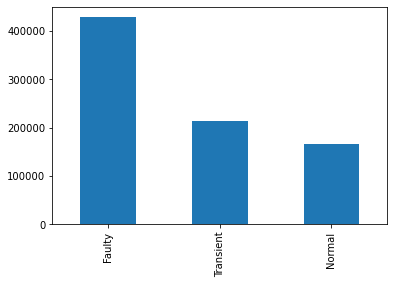

In [210]:
df2['Class_type'].value_counts().plot(kind = 'bar')

<AxesSubplot:title={'center':'Transient Conditions'}>

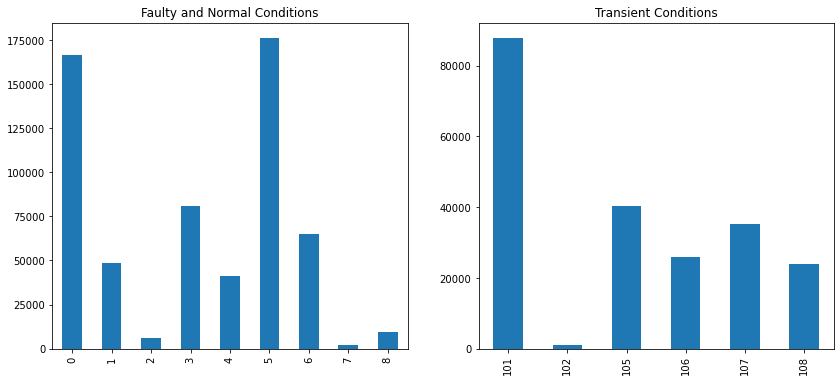

In [211]:
plot_objects = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig, ((ax1, ax2)) = plot_objects

df2['class'][(df2['Class_type'] == 'Faulty') |(df2['Class_type'] == 'Normal') ].value_counts().sort_index().plot(kind = 'bar', 
                                                                                                                 ax   = ax1, 
                                                                                                                title = 'Faulty and Normal Conditions'
                                                                                                                )
df2['class'][df2['Class_type'] == 'Transient'].value_counts().sort_index().plot(kind = 'bar', 
                                                                                ax = ax2,
                                                                                title = 'Transient Conditions'
                                                                                )

# Add description 

In [212]:
skim(df2)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types               Categories                  │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩          │
│ │ Number of rows    │ 809660 │ │ float64     │ 4     │ │ Class_type            │          │
│ │ Number of columns │ 8      │ │ category    │ 2     │ │ Fault_Type            │          │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │ └───────────────────────┘          │
│                                │ int32       │ 1     │                                    │
│                                └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┓  │
│ ┃        ┃ missin ┃ comple ┃ mean   ┃ sd     ┃ p0   ┃ p25    ┃ p75    ┃ p100   ┃ hist  ┃  │
│ ┃        ┃ g      ┃ te     ┃        ┃        ┃      ┃        ┃        ┃        ┃       ┃  │
│ ┃        ┃        ┃ rate   ┃        ┃        ┃      ┃        ┃        ┃        ┃       ┃  │
│ ┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━┩  │
│ │ P-PDG  │      0 │      1 │ 190000 │ 120000 │    0 │ 120000 │ 260000 │ 450000 │ ▅▁▆█▁ │  │
│ │        │        │        │     00 │     00 │      │     00 │     00 │     00 │   ▁   │  │
│ │ P-TPT  │      0 │      1 │ 140000 │ 570000 │    0 │ 110000 │ 180000 │ 320000 │ ▁▄█▆  │  │
│ │        │        │        │     00 │      0 │      │     00 │     00 │     00 │       │  │
│ │ P-MON- │      0 │      1 │ 350000 │ 330000 │   10 │ 120000 │ 490000 │ 130000 │ █▃▁▁▁ │  │
│ │ CKP    │        │        │      0 │      0 │      │      0 │      0 │     00 │   ▁   │  │
│ │ T-JUS- │      0 │      1 │     76 │     22 │ -1.7 │     67 │     85 │    170 │  ▂█▃  │  │
│ │ CKP    │        │        │        │        │      │        │        │        │       │  │
│ │ class  │      0 │      1 │     30 │     45 │    0 │      1 │    100 │    110 │   █   │  │
│ │        │        │        │        │        │      │        │        │        │   ▃   │  │
│ └────────┴────────┴────────┴────────┴────────┴──────┴────────┴────────┴────────┴───────┘  │
│                                         category                                          │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃                   ┃ missing      ┃ complete rate         ┃ ordered      ┃ unique     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ Class_type        │            0 │                     1 │ False        │          3 │  │
│ │ Fault_Type        │            0 │                     1 │ False        │         15 │  │
│ └───────────────────┴──────────────┴───────────────────────┴──────────────┴────────────┘  │
│                                         datetime                                          │
│ ┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃           ┃ missing ┃ complete rate ┃ first           ┃ last             ┃ frequency ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ timestamp │       0 │             1 │   2013-11-04    │    2018-10-07    │ None      │  │
│ │           │         │               │    01:41:00     │     21:12:00     │           │  │
│ └───────────┴─────────┴───────────────┴─────────────────┴──────────────────┴───────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

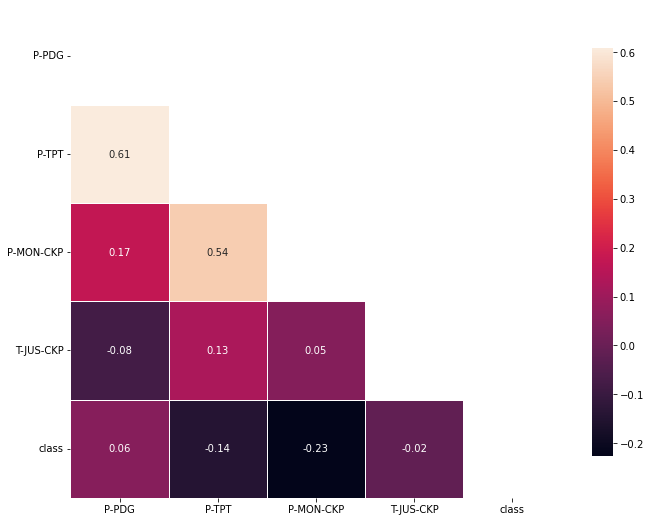

In [214]:
##create correlation table 
df_corr = df2.corr()

##create mask to remove upper boundaries 
mask = np.zeros_like(df_corr, dtype = bool)
mask[np.triu_indices_from(mask)]= True

##plot heatmap
f, ax = plt.subplots(figsize=(11, 15))
sns.heatmap(df_corr, annot=True, fmt='.2f', mask=mask, 
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
#add the column names as labels
ax.set_yticklabels(df_corr.columns, rotation = 0)
ax.set_xticklabels(df_corr.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

<AxesSubplot:xlabel='Class_type', ylabel='T-JUS-CKP'>

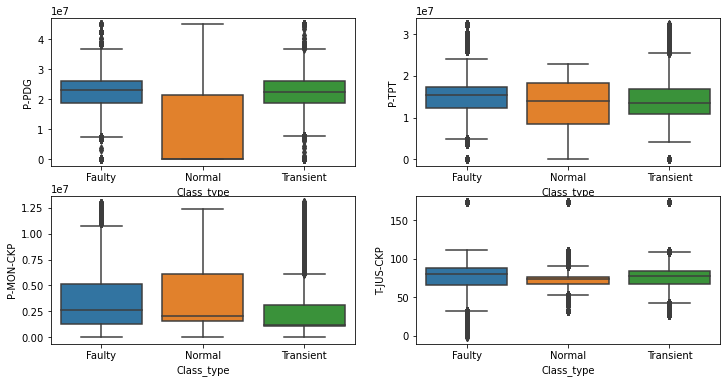

In [215]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12,6))

#create boxplot in each subplot
sns.boxplot(data = df2 , y = 'P-PDG',    x = 'Class_type',  ax=axes[0,0])
sns.boxplot(data = df2 , y = 'P-TPT',    x = 'Class_type',  ax=axes[0,1])
sns.boxplot(data = df2 , y = 'P-MON-CKP',x = 'Class_type',  ax=axes[1,0])
sns.boxplot(data = df2 , y = 'T-JUS-CKP',x = 'Class_type',  ax=axes[1,1])

<AxesSubplot:xlabel='T-JUS-CKP', ylabel='Density'>

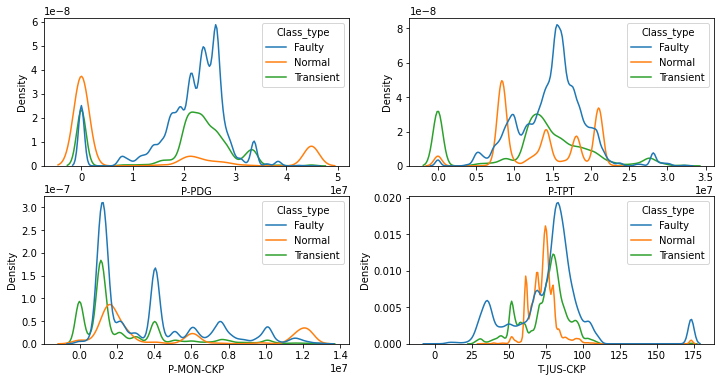

In [217]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
sns.kdeplot(data=df2, x="P-PDG",     hue="Class_type", ax=axes[0,0])
sns.kdeplot(data=df2, x="P-TPT",     hue="Class_type", ax=axes[0,1])
sns.kdeplot(data=df2, x="P-MON-CKP", hue="Class_type", ax=axes[1,0])
sns.kdeplot(data=df2, x="T-JUS-CKP", hue="Class_type", ax=axes[1,1])

<AxesSubplot:xlabel='T-JUS-CKP', ylabel='Proportion'>

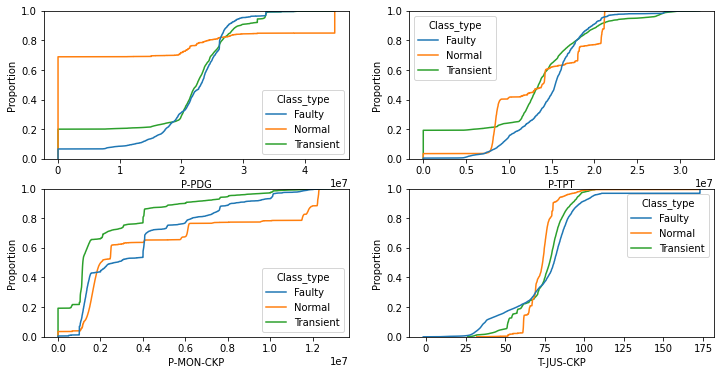

In [219]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
sns.ecdfplot(data = df2, x = "P-PDG",     hue = "Class_type", ax = axes[0,0])
sns.ecdfplot(data = df2, x = "P-TPT",     hue = "Class_type", ax = axes[0,1])
sns.ecdfplot(data = df2, x = "P-MON-CKP", hue = "Class_type", ax = axes[1,0])
sns.ecdfplot(data = df2, x = "T-JUS-CKP", hue = "Class_type", ax = axes[1,1])

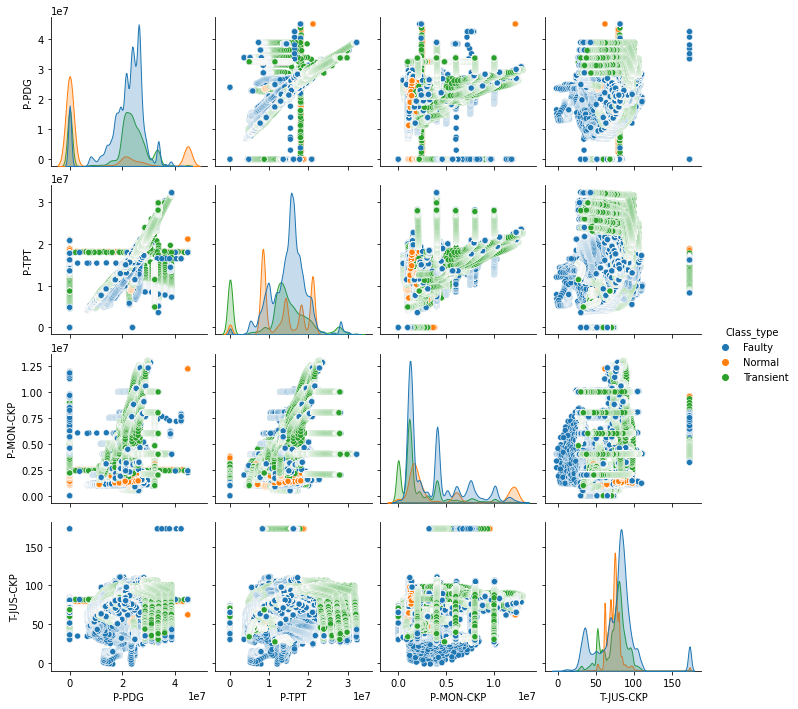

In [220]:
Columns = list(df2.columns)
sns.pairplot(data = df2[Columns[:7]].drop(["class", 'timestamp'], axis="columns"), 
              hue = "Class_type")

## MODEL CREATION
> - Choose NN architecture
> - Normalization 
> - Create dense layers 
> - Evaluate and tune hyper-parameters 
> - 

In [221]:
# IMPORT MACHINE LEARNING LIBRARIES 

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Normalization


# Choosen DNN architecture 

<img src="DNN architecture.jpg">

In [222]:
input_features  = tf.convert_to_tensor(df2.iloc[:, 1:5])

test_norm = Normalization(input_shape=input_features.shape, axis=-1)
test_norm.adapt(input_features)

In [ ]:
# Create DNN of choose architecture 

horsepower = np.array(train_features['Horsepower'])

layers.Normalization(input_shape=[1,], axis=None).adapt(horsepower)

#model1 = Sequential(
#    [
#        Dense(4, activation = 'relu',    name = "L1"),
#        Dense(16, activation = 'relu',   name = "L2"),
#        Dense(32, activation  = 'relu',  name = "L3"),
#        Dense(16, activation  = 'relu',  name = "L3"),
#        Dense(4, activation  = 'softmax',name = "L4")
#    ]
#)

